In [6]:
#Import Modules
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import cv2
import imutils
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76
import os

In [7]:
#Define RGB to Hexadecimal Conversion
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

In [12]:
#Set path to file
filename = 'Cropped.jpg'

1. Notes on Color Adjustments:
    Currently, the biggest issue is that we aren't adjusting the image's RGB values based off of the
    RGB guide/table provided in the corners of each image. The next step would be to use these values
    to adjust the values to a "standardized" system. The adjustment made in each image would also need
    to be tracked for the researcher's data. The original "guide" image is included in the repo as guide.pdf

2. Notes on Image Processing:
    I feel that the current biggest issue with the image processing is the method of defining the contours/edges. It does a fairly
    consist job of finding the proper edges, but there are still cases where it detects/leaves spaces between soybean pods that are
    close together. It also expands edges past the true edge of the pod. We tried various methods and settings to attempt making
    this more precise, but the current code is what we found to work best.

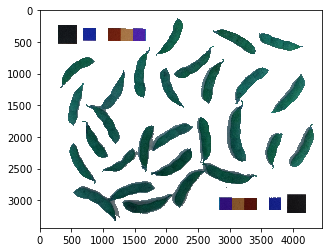

In [9]:
# load image and convert to HSV
img = cv2.imread(filename)
hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

#Set green values for detection
green_low = np.array([45, 100, 50])
green_high = np.array([75, 255, 255])
curr_mask = cv2.inRange(hsv_img, green_low, green_high)
hsv_img[curr_mask > 0] = ([75,255,200])                       

#Convert to RGB then Grayscale
RGB_again = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)
gray = cv2.cvtColor(RGB_again, cv2.COLOR_RGB2GRAY)                                            

# threshold input image using otsu thresholding as mask and refine with morphology
ret, mask = cv2.threshold(gray, 110, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU) 

#Setting mask values
kernel = np.ones((9,9), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

#Copy image and apply mask
result = img.copy()
result = cv2.cvtColor(result, cv2.COLOR_BGR2BGRA)
result[:, :, 3] = mask

#Display image
plt.imshow(result)

In [10]:
#Color detection & analysis
#Outline by Karan Bhanot - https://gist.github.com/kb22
def get_colors(image, number_of_colors):
    
    #Convert from BGRA to RGBA and display
    image = cv2.cvtColor(image, cv2.COLOR_BGRA2RGBA)
    plt.imshow(image)
    
    #Resize and reshape array for analysis
    modified_image = cv2.resize(image, (600, 400), interpolation = cv2.INTER_AREA)  
    modified_image = modified_image.reshape(modified_image.shape[0]*modified_image.shape[1], 4)
    
    #Find mean colors and prepare labels
    clf = KMeans(n_clusters = number_of_colors)
    labels = clf.fit_predict(modified_image)
    
    #Sort for correct color percentage
    counts = Counter(labels)
    counts = dict(sorted(counts.items()))
    center_colors = clf.cluster_centers_
    
    #Iterate through the keys in order
    ordered_colors = [center_colors[i] for i in counts.keys()]
    hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
    rgb_colors = [ordered_colors[i] for i in counts.keys()]
    
    #Display figure and pie chart
    plt.figure(figsize = (8, 6))
    plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)
    
    return rgb_colors

[array([ 23.88042406,  25.91272189,  43.0219428 , 254.75641026]),
 array([1.77727836e+02, 1.71040805e+02, 1.59800720e+02, 5.93963248e-03]),
 array([109.35103614, 101.62255422,  84.50708434, 240.22371084]),
 array([149.68887983, 142.58790985, 127.78027415,   0.45166953]),
 array([ 75.58362387,  80.4185039 ,  21.10087674, 254.93962777]),
 array([113.30737257, 119.61015095,  68.94005688,  54.97899803])]

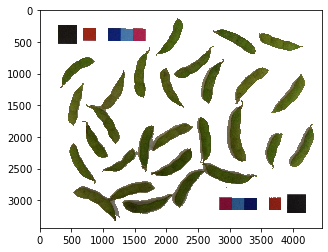

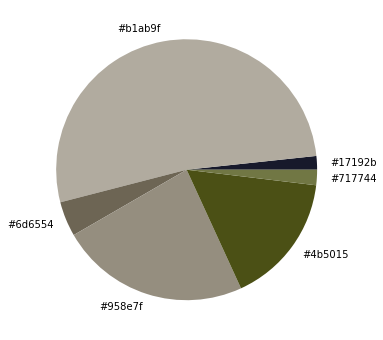

In [11]:
get_colors(result, 6)